In [1]:
# 모두의 딥러닝

In [2]:
# 19장 세상에 없는 얼굴 GAN, 오토인코더

In [3]:
# 19-1 가짜 제조 공장, 생성자

In [4]:
# 19-2 진위를 가려내는 장치, 판별자

In [5]:
# 19-3 적대적 신경망 실행하기

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

In [7]:
# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [8]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [9]:
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


epoch:0  d_loss:0.5891  g_loss:0.3025
epoch:1  d_loss:0.5452  g_loss:0.2427
epoch:2  d_loss:0.4988  g_loss:0.2952
epoch:3  d_loss:0.4888  g_loss:0.3810
epoch:4  d_loss:0.4687  g_loss:0.5110
epoch:5  d_loss:0.4966  g_loss:0.5497
epoch:6  d_loss:0.5126  g_loss:0.5880
epoch:7  d_loss:0.6150  g_loss:0.4010
epoch:8  d_loss:0.6915  g_loss:0.3387
epoch:9  d_loss:0.6546  g_loss:0.4048
epoch:10  d_loss:0.7241  g_loss:0.4049
epoch:11  d_loss:0.6374  g_loss:0.5566
epoch:12  d_loss:0.5959  g_loss:0.6346
epoch:13  d_loss:0.5160  g_loss:0.7357
epoch:14  d_loss:0.5403  g_loss:0.7314
epoch:15  d_loss:0.5418  g_loss:0.7864
epoch:16  d_loss:0.5228  g_loss:0.8599
epoch:17  d_loss:0.5061  g_loss:0.8154
epoch:18  d_loss:0.5424  g_loss:0.7682
epoch:19  d_loss:0.5138  g_loss:0.8184
epoch:20  d_loss:0.4929  g_loss:0.8254
epoch:21  d_loss:0.4730  g_loss:0.9651
epoch:22  d_loss:0.5119  g_loss:0.9679
epoch:23  d_loss:0.4695  g_loss:1.0475
epoch:24  d_loss:0.4491  g_loss:1.0292
epoch:25  d_loss:0.4488  g_loss:1.0

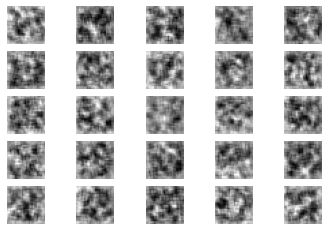

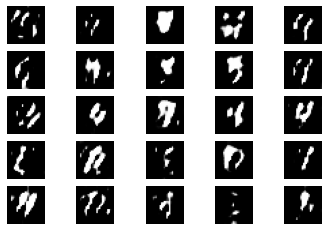

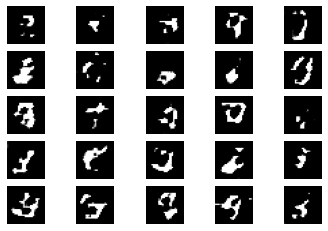

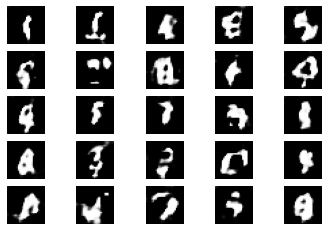

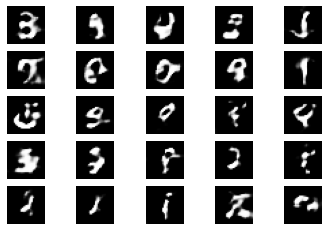

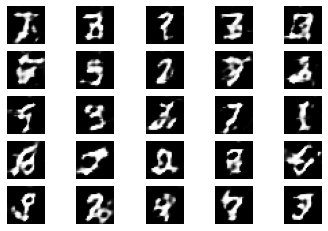

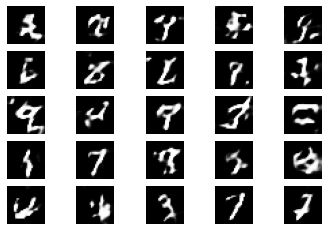

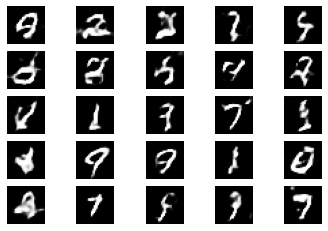

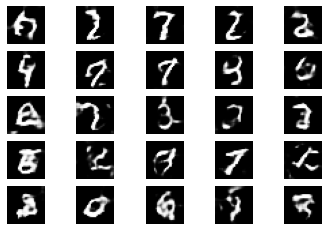

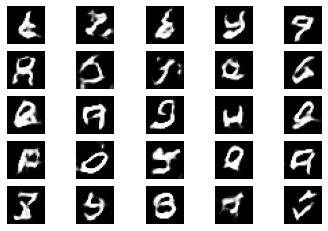

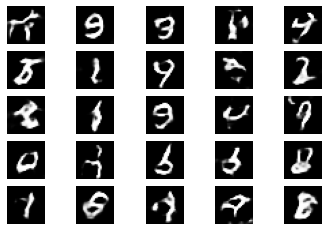

In [11]:
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("gan_images/gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.

In [12]:
# 19-4 이미지의 특징을 추출하는 오토인코더

In [13]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

In [14]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [15]:
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

In [16]:
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

In [18]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 79s 167ms/step - loss: 0.0848 - val_loss: 0.0823
Epoch 2/50
469/469 [==============================] - 74s 157ms/step - loss: 0.0832 - val_loss: 0.0824
Epoch 3/50
469/469 [==============================] - 73s 156ms/step - loss: 0.0832 - val_loss: 0.0822
Epoch 4/50
469/469 [==============================] - 73s 156ms/step - loss: 0.0832 - val_loss: 0.0821
Epoch 5/50
469/469 [==============================] - 73s 156ms/step - loss: 0.0831 - val_loss: 0.0819
Epoch 6/50
469/469 [==============================] - 73s 156ms/step - loss: 0.0830 - val_loss: 0.0822
Epoch 7/50
469/469 [==============================] - 73s 156ms/step - loss: 0.0830 - val_loss: 0.0817
Epoch 8/50
469/469 [==============================] - 72s 154ms/step - loss: 0.0828 - val_loss: 0.0817
Epoch 9/50
469/469 [==============================] - 73s 156ms/step - loss: 0.0828 - val_loss: 0.0818
Epoch 10/50
469/469 [==============================] - 73s 156ms/step - l

In [19]:
random_test = np.random.randint(X_test.shape[0], size=5)

In [20]:
ae_imgs = autoencoder.predict(X_test)

In [21]:
plt.figure(figsize=(7,2))

<Figure size 504x144 with 0 Axes>

<Figure size 504x144 with 0 Axes>

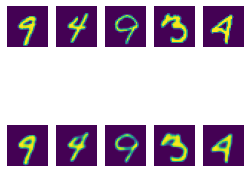

In [22]:
for i, image_idx in enumerate(random_test):
  ax = plt.subplot(2,7,i+1)
  plt.imshow(X_test[image_idx].reshape(28,28))
  ax.axis('off')
  ax = plt.subplot(2, 7, 7+i+1)
  plt.imshow(ae_imgs[image_idx].reshape(28,28))
  ax.axis('off')

plt.show()